<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Functions and Load Data

In [1]:
import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    Loads covid_data into new dataframe, merges population and continent fields 
    from pop_data, and passes to munge_data() and order_columns() for
    further processing. This is the first function called after importing
    CSV files.

    Parameters
    ----------
    covid_data (pd.DataFrame) : raw data from Covid-19 CSV file [1] or similar
    pop_data (pd.DataFrame) : raw data from population CSV file [2] or similar
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    
    Notes
    ----
    [1] https://covid.ourworldindata.org/data/ecdc/locations.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe to be processed
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['cases_pct_of_pop'] = df['total_cases']/df['population'] * 100       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['repro_number'] = df['new_cases']/df['contagious'] * contagious_days
    
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['days_to_dbl'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'days_to_dbl']] = np.NaN
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'cases_pct_of_pop', 
                    'new_deaths', 'total_deaths', 'fatality', 
                    'contagious', 'repro_number', 'growth', 
                    'days_to_dbl', 'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def new_repro(days, last, move=[]):
    '''
    Forecasts reproduction numbers.

    Parameters
    ----------
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    move[0] (float) : target reproduction number 
    move[1] (float) : daily rate of change from last to target       
    move[2] (float) : default 0; x_0, the x value of the sigmoid's midpoint [1]
    move[3] (float): default 1; k, the logistic growth rate 
                    or steepness of the curve [1]

    Returns
    -------
    pd.Series: series of forecast reproduction numbers
    
    Notes
    -----
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    days_motion = round(1/rate) if rate else days
    L = target - last

    y = []
    for x in np.linspace(-6, 6, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, repro_move=[],
             contagious_days=14, replace=True):
    '''
    Forecasts reproduction numbers.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe of inputs to forecast
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    repro_move (list of floats) : parameters for reproduction number motion
        see new_repro() docstring for details on list items
    contagious_days (int) : number of days infected person assumed contagious
    replace (bool) : if True, replace existing forecast records

    Returns
    -------
    pd.DataFrame: dataframe with appended forecast records
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        last_repro = df.iloc[-1]['repro_number']
        new_repros = new_repro(days, last_repro, repro_move)

        for i in range(days):

            last = df.iloc[-1]
            repro_number_ = new_repros[i]  
            
            pop_adjustment = 1 - last['cases_pct_of_pop']/100
            trans_rate = last['repro_number']/contagious_days

            new_cases_ = ((last['contagious'] + last['new_cases']) 
                          * trans_rate * pop_adjustment)
            total_cases_ = last['total_cases'] + new_cases_
            cases_pct_of_pop_ = total_cases_/last['population'] * 100
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days + 1]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            days_to_dbl_ = np.log(2)/growth_
            total_deaths_ = total_cases_ * last['fatality']
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'cases_pct_of_pop': cases_pct_of_pop_,
                    'repro_number': repro_number_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'days_to_dbl': days_to_dbl_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': last['fatality'],
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 20
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['total_deaths', 'new_cases'],
             right='repro_number',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number',
             left_yscale=1000):
    '''
    Lineplots time series of Total Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                min_count=10, logy=True):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    locations (list of str) : names of locations to be plotted
    column (str) : name of column to be plotted for each location
    title (str) : plot title
    min_count (int) : starting value for the plotted columns
    logy (bool) : if True, configure y-axis as a log(10) scale
    '''
    
    data = df.copy()
    data = data[data[column] >= min_count]

    data['day_num'] = data.groupby(level=0).cumcount()
    data.loc[data['day_num'] == 0, column] = min_count
    data.reset_index(inplace=True)

    pivoted = data.pivot(index='day_num', columns='location', values=column)
    pivoted.index.name = "days since " + str(min_count) + " " + column

    pivoted[locations].plot(logy=logy, title=title or column)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load country data

In [2]:
covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=14)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Load U.S. state-level data

In [0]:
#https://github.com/nytimes/covid-19-data
covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/'
                                'covid-19-data/master/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index(['location','date'], inplace=True)
covid_state_data.sort_index(inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index.levels[0]:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)

#https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=14)

## United States

Where we are today:

In [4]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-10,Fri,33901,466033,0.140794,1873,16690,0.035813,380042.0,1.248846,0.075525,9.177676,actual,331002647.0,North America
2020-04-11,Sat,35527,501560,0.151527,2087,18777,0.037437,396874.0,1.253239,0.073467,9.434836,actual,331002647.0,North America
2020-04-12,Sun,28391,529951,0.160105,1831,20608,0.038887,405286.0,0.980725,0.055061,12.588644,actual,331002647.0,North America
2020-04-13,Mon,27620,557571,0.168449,1500,22108,0.039651,414546.0,0.932779,0.050805,13.643206,actual,331002647.0,North America
2020-04-14,Tue,25023,582594,0.176009,1541,23649,0.040593,417974.0,0.838143,0.043901,15.788979,actual,331002647.0,North America
2020-04-15,Wed,26922,609516,0.184142,2408,26057,0.042750,419898.0,0.897618,0.045175,15.343719,actual,331002647.0,North America
2020-04-16,Thu,30148,639664,0.193250,4928,30985,0.048439,422943.0,0.997941,0.048278,14.357461,actual,331002647.0,North America


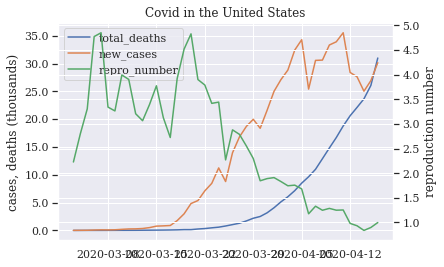

In [5]:
plot_cdr(US_Cov[US_Cov['source']=='actual'], 
         'Covid in the United States','W')

and in 100 days.

In [6]:
days_back = 14
target = 0.7
repros = US_Cov[US_Cov['source']=='actual'].repro_number - target
repros.pct_change().tail(days_back).mean()

-0.04105844444022201

In [7]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.04, -4])
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-07-19,Sun,255.030938,1.256557e+06,0.379622,12.353569,60866.997844,0.048439,4606.856411,0.700014,0.000203,3414.843515,forecast,331002647.0,North America
2020-07-20,Mon,242.176208,1.256799e+06,0.379695,11.730893,60878.728737,0.048439,4374.652198,0.700014,0.000193,3596.815190,forecast,331002647.0,North America
2020-07-21,Tue,229.969371,1.257029e+06,0.379764,11.139600,60889.868337,0.048439,4154.151225,0.700014,0.000183,3788.446668,forecast,331002647.0,North America
2020-07-22,Wed,218.377783,1.257248e+06,0.379830,10.578109,60900.446446,0.048439,3944.763892,0.700014,0.000174,3990.250611,forecast,331002647.0,North America
2020-07-23,Thu,207.370447,1.257455e+06,0.379893,10.044919,60910.491365,0.048439,3745.930273,0.700014,0.000165,4202.766828,forecast,331002647.0,North America
2020-07-24,Fri,196.917926,1.257652e+06,0.379952,9.538605,60920.029970,0.048439,3557.118580,0.700014,0.000157,4426.563756,forecast,331002647.0,North America
2020-07-25,Sat,186.992261,1.257839e+06,0.380009,9.057810,60929.087780,0.048439,3377.823737,0.700014,0.000149,4662.240038,forecast,331002647.0,North America


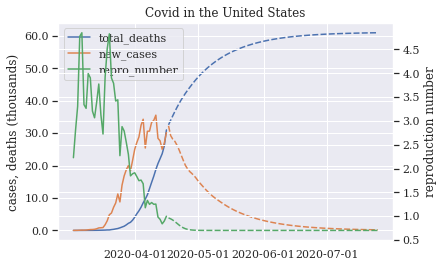

In [8]:
plot_cdr(default_scenario, 'Covid in the United States')

### Relax Too Early Scenario

In [9]:
forecast_days = 100
relax_date = date(2020, 5, 1) #Easter is 4/12/2020
relax_days = 14

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()
stage_1 = (relax_date - last_actual).days
stage_2 = relax_days
stage_3 = forecast_days - stage_1 - stage_2

US_Cov = forecast(US_Cov, stage_1, repro_move=[0.7, 0.08, -4], replace=True)
US_Cov = forecast(US_Cov, stage_2, repro_move=[1.5, 0.08,  0], replace=False)
US_Cov = forecast(US_Cov, stage_3, repro_move=[0.7, 0.08,  0], replace=False)

relax_scenario = US_Cov.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-07-19,Sun,1285.840246,1.840245e+06,0.555961,62.285450,89140.523558,0.048439,23204.438049,0.701973,0.000699,991.658785,forecast,331002647.0,North America
2020-07-20,Mon,1221.138651,1.841466e+06,0.556330,59.151337,89199.674896,0.048439,22037.185126,0.701973,0.000663,1044.912986,forecast,331002647.0,North America
2020-07-21,Tue,1159.706411,1.842626e+06,0.556680,56.175591,89255.850487,0.048439,20929.022395,0.701973,0.000630,1100.975871,forecast,331002647.0,North America
2020-07-22,Wed,1101.384193,1.843727e+06,0.557013,53.350492,89309.200979,0.048439,19876.937356,0.701973,0.000598,1159.987971,forecast,331002647.0,North America
2020-07-23,Thu,1046.013767,1.844773e+06,0.557329,50.668377,89359.869356,0.048439,18877.988453,0.701973,0.000567,1222.103083,forecast,331002647.0,North America
2020-07-24,Fri,993.440507,1.845766e+06,0.557629,48.121755,89407.991110,0.048439,17929.351322,0.701973,0.000538,1287.488748,forecast,331002647.0,North America
2020-07-25,Sat,943.515814,1.846710e+06,0.557914,45.703428,89453.694538,0.048439,17028.357066,0.701973,0.000511,1356.325731,forecast,331002647.0,North America


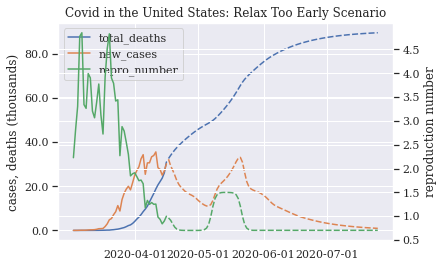

In [10]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario')

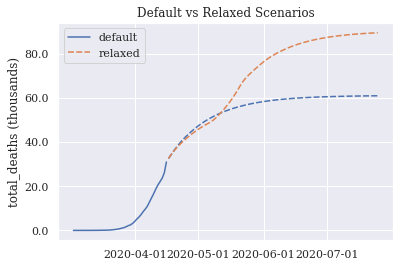

In [11]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

### No Further Improvements Scenario

In [12]:
US_Cov = forecast(US_Cov, 200)
US_Cov.tail(7).round(2)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-10-27,Tue,20727.86,5679322.95,1.72,1004.05,275103.53,0.05,274258.44,1.0,0.0,189.57,forecast,331002647.0,North America
2020-10-28,Wed,20666.28,5699989.22,1.72,1001.06,276104.59,0.05,273459.53,1.0,0.0,190.83,forecast,331002647.0,North America
2020-10-29,Thu,20604.68,5720593.91,1.73,998.08,277102.67,0.05,272660.31,1.0,0.0,192.10,forecast,331002647.0,North America
2020-10-30,Fri,20543.08,5741136.99,1.73,995.10,278097.77,0.05,271860.81,1.0,0.0,193.37,forecast,331002647.0,North America
2020-10-31,Sat,20481.46,5761618.45,1.74,992.11,279089.88,0.05,271061.05,1.0,0.0,194.64,forecast,331002647.0,North America
2020-11-01,Sun,20419.84,5782038.30,1.75,989.13,280079.00,0.05,270261.06,1.0,0.0,195.92,forecast,331002647.0,North America
2020-11-02,Mon,20358.22,5802396.51,1.75,986.14,281065.15,0.05,269460.85,1.0,0.0,197.21,forecast,331002647.0,North America


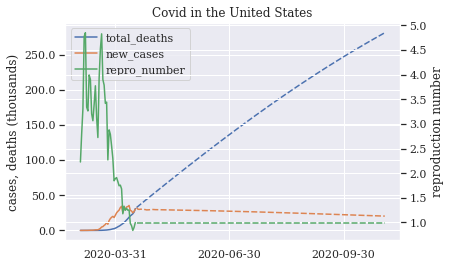

In [13]:
plot_cdr(US_Cov, 'Covid in the United States', date_freq='Q')

## Other Countries

### China

In [14]:
China_Cov = df[df['total_cases']>100].loc['China']
China_Cov[China_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-10,Fri,55,82925,0.005761,1,3340,0.040277,1098.0,0.701275,0.000663,1044.730296,actual,1.439324e+09,Asia
2020-04-11,Sat,79,83004,0.005767,3,3343,0.040275,1058.0,1.045369,0.000952,727.931708,actual,1.439324e+09,Asia
2020-04-12,Sun,93,83097,0.005773,0,3343,0.040230,1038.0,1.254335,0.001120,618.991547,actual,1.439324e+09,Asia
2020-04-13,Mon,112,83209,0.005781,2,3345,0.040200,1052.0,1.490494,0.001347,514.618382,actual,1.439324e+09,Asia
2020-04-14,Tue,94,83303,0.005788,0,3345,0.040155,1062.0,1.239171,0.001129,613.921867,actual,1.439324e+09,Asia
2020-04-15,Wed,49,83352,0.005791,1,3346,0.040143,1057.0,0.649007,0.000588,1178.739184,actual,1.439324e+09,Asia
2020-04-16,Thu,50,83402,0.005795,0,3346,0.040119,1007.0,0.695134,0.000600,1155.850615,actual,1.439324e+09,Asia


In [15]:
days_back = 21
target = 0.7
repros= China_Cov[China_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

13.105112873744261

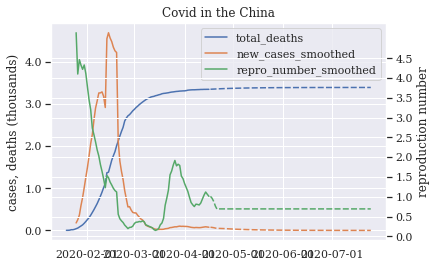

In [16]:
China_Cov = forecast(China_Cov, 100, repro_move=[-0.5, 0.7])

China_Cov['new_cases_smoothed']=China_Cov['new_cases'].rolling(7).mean()
China_Cov['repro_number_smoothed']=China_Cov['repro_number'].rolling(7).mean()
plot_cdr(China_Cov, 'Covid in the China',
         left = ['total_deaths', 'new_cases_smoothed'],
         right='repro_number_smoothed')

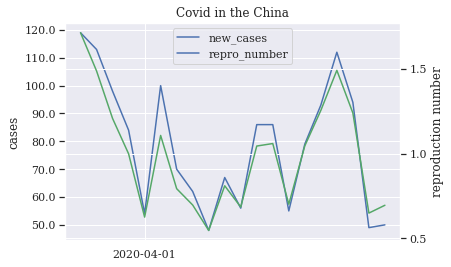

In [17]:
plot_cdr(China_Cov[China_Cov['source']=='actual'].tail(20), 'Covid in the China',
         left = ['new_cases'],
         right='repro_number',
         left_ylabel='cases',
         left_yscale=1)

### Italy

In [18]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-10,Fri,4204,143626,0.237548,612,18281,0.127282,63087.0,0.932934,0.029707,23.332480,actual,60461828.0,Europe
2020-04-11,Sat,3951,147577,0.244083,570,18851,0.127737,61079.0,0.905614,0.027137,25.542160,actual,60461828.0,Europe
2020-04-12,Sun,4694,152271,0.251847,619,19470,0.127864,59799.0,1.098948,0.031312,22.136964,actual,60461828.0,Europe
2020-04-13,Mon,4092,156363,0.258614,431,19901,0.127274,58674.0,0.976378,0.026518,26.138349,actual,60461828.0,Europe
2020-04-14,Tue,3153,159516,0.263829,564,20465,0.128294,57777.0,0.764006,0.019964,34.719849,actual,60461828.0,Europe
2020-04-15,Wed,2972,162488,0.268745,604,21069,0.129665,56696.0,0.733879,0.018460,37.548760,actual,60461828.0,Europe
2020-04-16,Thu,2667,165155,0.273156,578,21647,0.131071,54581.0,0.684084,0.016280,42.575892,actual,60461828.0,Europe


In [19]:
days_back = 21
target = 0.7
repros= Italy_Cov[Italy_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-0.34054657760509044

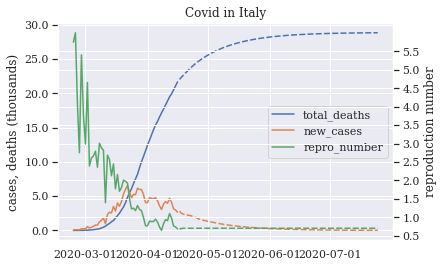

In [20]:
Italy_Cov = forecast(Italy_Cov, 100, repro_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Sweden

In [21]:
Sweden_Cov = df[df['total_cases']>1000].loc['Sweden']
Sweden_Cov[Sweden_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-10,Fri,722,9141,0.090511,106,793,0.086752,6335.0,1.595580,0.082279,8.424378,actual,10099270.0,Europe
2020-04-11,Sat,544,9685,0.095898,77,870,0.089830,6639.0,1.147161,0.057809,11.990401,actual,10099270.0,Europe
2020-04-12,Sun,466,10151,0.100512,17,887,0.087381,6704.0,0.973150,0.046994,14.749719,actual,10099270.0,Europe
2020-04-13,Mon,332,10483,0.103800,12,899,0.085758,6783.0,0.685243,0.032183,21.537899,actual,10099270.0,Europe
2020-04-14,Tue,465,10948,0.108404,20,919,0.083942,6920.0,0.940751,0.043402,15.970436,actual,10099270.0,Europe
2020-04-15,Wed,497,11445,0.113325,114,1033,0.090258,7010.0,0.992582,0.044396,15.612772,actual,10099270.0,Europe
2020-04-16,Thu,482,11927,0.118098,170,1203,0.100864,6980.0,0.966762,0.041252,16.802841,actual,10099270.0,Europe


In [22]:
days_back = 14
target = 0.7
repros= Sweden_Cov[Sweden_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-1.3238109419401813

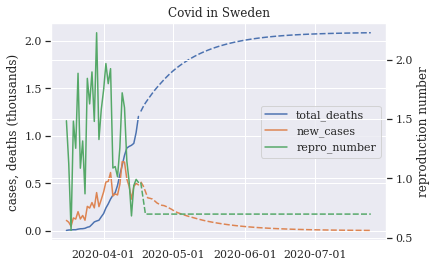

In [23]:
Sweden_Cov = forecast(Sweden_Cov, 100, repro_move=[0.7, 0.3])
plot_cdr(Sweden_Cov, 'Covid in Sweden')

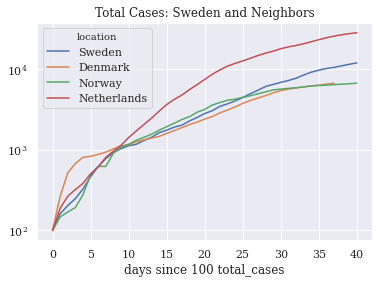

In [24]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Denmark','Norway','Netherlands'], 
            title='Total Cases: Sweden and Neighbors',logy=True, 
            min_count=100, column='total_cases')

## The World, Country and Regional Comparisons

In [25]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=14)
World_Cov = order_columns(World_Cov).loc['world']
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-10,Fri,87039,1563161,0.020202,7223,95032,0.060795,1036090.0,1.176101,0.057292,12.098567,actual,7.737500e+09,NaN
2020-04-11,Sat,89349,1652510,0.021357,7049,102081,0.061773,1061516.0,1.178396,0.055585,12.469975,actual,7.737500e+09,NaN
2020-04-12,Sun,81707,1734217,0.022413,6104,108185,0.062383,1078045.0,1.061086,0.048261,14.362568,actual,7.737500e+09,NaN
2020-04-13,Mon,72390,1806607,0.023349,5321,113506,0.062828,1091945.0,0.928124,0.040894,16.949649,actual,7.737500e+09,NaN
2020-04-14,Tue,65962,1872569,0.024201,5339,118845,0.063466,1096224.0,0.842408,0.035861,19.328835,actual,7.737500e+09,NaN
2020-04-15,Wed,75246,1947815,0.025174,7114,125959,0.064667,1097175.0,0.960142,0.039397,17.593931,actual,7.737500e+09,NaN
2020-04-16,Thu,81419,2029234,0.026226,10354,136313,0.067175,1101440.0,1.034887,0.040950,16.926609,actual,7.737500e+09,NaN


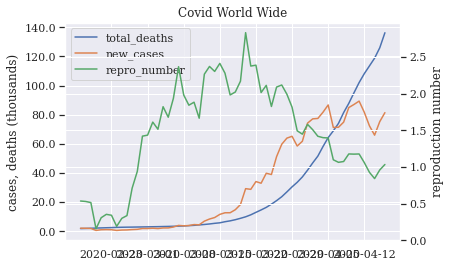

In [26]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide','W')

In [27]:
df[df['source']=='actual'].groupby('location')[['growth','days_to_dbl']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,days_to_dbl
location,,
Cape Verde,1.609438,0.430677
Tanzania,0.507045,1.367033
Congo,0.458109,1.513062
Bermuda,0.351398,1.972542
Libya,0.315853,2.194525
Zimbabwe,0.302281,2.293057
Somalia,0.287682,2.409421
Equatorial Guinea,0.218254,3.175880
Ukraine,0.210249,3.296786


In [28]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
Europe,923265
North America,685366
Asia,332689
South America,62890
Africa,17243
Oceania,7781


In [29]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','repro_number']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,repro_number
1,United States,639664,0.997941
2,Spain,177633,0.944249
3,Italy,165155,0.684084
4,Germany,130450,0.704820
5,France,106206,0.748969


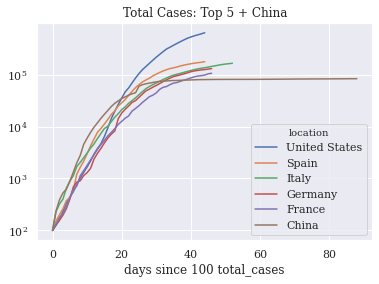

In [30]:
plot_growth(df[df['source']=='actual'], 
            top5['location'].append(pd.Series('China', index=[6])), 
            title='Total Cases: Top 5 + China',logy=True, 
            min_count=100, column='total_cases')

## U.S. States

### Oklahoma

In [31]:
OK_Cov = df_states[df_states['total_cases']>10].loc['Oklahoma']
OK_Cov[OK_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-09,Thu,160.0,1684,0.042558,1.0,80,0.047506,1436.0,1.559889,0.099833,6.943035,actual,3956971,NA
2020-04-10,Fri,110.0,1794,0.045338,8.0,88,0.049052,1472.0,1.046196,0.063276,10.954372,actual,3956971,NA
2020-04-11,Sat,74.0,1868,0.047208,5.0,93,0.049786,1491.0,0.694836,0.040421,17.148375,actual,3956971,NA
2020-04-12,Sun,102.0,1970,0.049786,3.0,96,0.048731,1541.0,0.926671,0.053165,13.037610,actual,3956971,NA
2020-04-13,Mon,99.0,2069,0.052287,2.0,98,0.047366,1588.0,0.872796,0.049032,14.136670,actual,3956971,NA
2020-04-14,Tue,115.0,2184,0.055194,11.0,109,0.049908,1618.0,0.995056,0.054093,12.814071,actual,3956971,NA
2020-04-15,Wed,79.0,2263,0.057190,14.0,123,0.054353,1544.0,0.716321,0.035533,19.506970,actual,3956971,NA


In [32]:
days_back = 21
target = 0.7
repros= OK_Cov[OK_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-2.444750119705189

In [33]:
OK_Cov = forecast(OK_Cov, 50, repro_move=(0.7, 0.3))
OK_Cov.tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-05-29,Fri,8.803059,3687.896987,0.093200,0.478469,200.446898,0.054353,158.584495,0.70004,0.002390,290.035930,forecast,3956971,NA
2020-05-30,Sat,8.362059,3696.259046,0.093411,0.454500,200.901398,0.054353,150.637847,0.70004,0.002265,306.043311,forecast,3956971,NA
2020-05-31,Sun,7.943027,3704.202073,0.093612,0.431724,201.333122,0.054353,143.089749,0.70004,0.002147,322.899996,forecast,3956971,NA
2020-06-01,Mon,7.545005,3711.747078,0.093803,0.410091,201.743213,0.054353,135.924543,0.70004,0.002035,340.645421,forecast,3956971,NA
2020-06-02,Tue,7.167162,3718.914239,0.093984,0.389554,202.132767,0.054353,129.120081,0.70004,0.001929,359.315208,forecast,3956971,NA
2020-06-03,Wed,6.808350,3725.722590,0.094156,0.370052,202.502819,0.054353,122.658867,0.70004,0.001829,378.963141,forecast,3956971,NA
2020-06-04,Thu,6.467639,3732.190228,0.094319,0.351533,202.854352,0.054353,116.525180,0.70004,0.001734,399.638123,forecast,3956971,NA


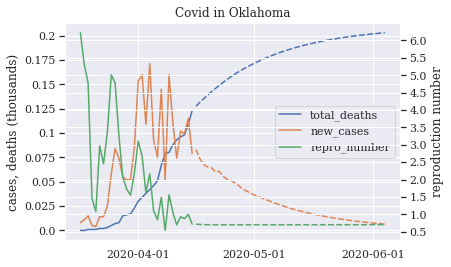

In [34]:
plot_cdr(OK_Cov, 'Covid in Oklahoma')

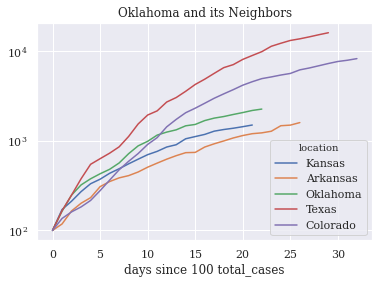

In [35]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Oklahoma and its Neighbors', logy=True, 
            min_count=100, column='total_cases')

### New York

In [36]:
NY_Cov = df_states[df_states['total_cases']>10].loc['Oklahoma']
NY_Cov[NY_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,cases_pct_of_pop,new_deaths,total_deaths,fatality,contagious,repro_number,growth,days_to_dbl,source,population,region
2020-04-09,Thu,160.0,1684,0.042558,1.0,80,0.047506,1436.0,1.559889,0.099833,6.943035,actual,3956971,NA
2020-04-10,Fri,110.0,1794,0.045338,8.0,88,0.049052,1472.0,1.046196,0.063276,10.954372,actual,3956971,NA
2020-04-11,Sat,74.0,1868,0.047208,5.0,93,0.049786,1491.0,0.694836,0.040421,17.148375,actual,3956971,NA
2020-04-12,Sun,102.0,1970,0.049786,3.0,96,0.048731,1541.0,0.926671,0.053165,13.037610,actual,3956971,NA
2020-04-13,Mon,99.0,2069,0.052287,2.0,98,0.047366,1588.0,0.872796,0.049032,14.136670,actual,3956971,NA
2020-04-14,Tue,115.0,2184,0.055194,11.0,109,0.049908,1618.0,0.995056,0.054093,12.814071,actual,3956971,NA
2020-04-15,Wed,79.0,2263,0.057190,14.0,123,0.054353,1544.0,0.716321,0.035533,19.506970,actual,3956971,NA


In [37]:
days_back = 21
target = 0.7
repros= NY_Cov[NY_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-2.444750119705189

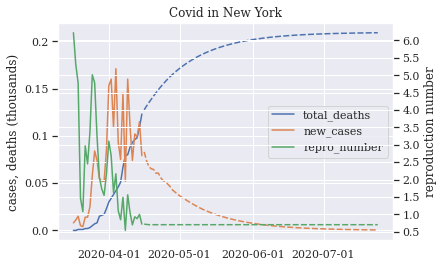

In [38]:
NY_Cov = forecast(NY_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(NY_Cov, 'Covid in New York')

## Comparing Reproduction Numbers

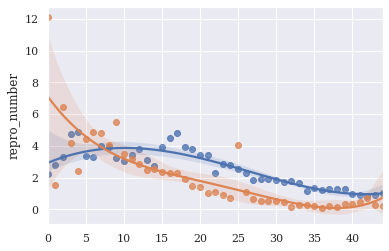

In [39]:
US_ = US_Cov[US_Cov['source']=='actual'].copy()
US_.reset_index(inplace=True)
days = len(US_)

China_ = China_Cov[China_Cov['source']=='actual'][:days].copy()
China_.reset_index(inplace=True)

sns.regplot(x=US_.index, y='repro_number', data=US_, fit_reg=True, order=4) 
sns.regplot(x=China_.index, y='repro_number', data=China_, fit_reg=True, order=4) 

In [40]:

y = US_.repro_number
x = y.index
np.polyfit(np.log(x), y, 1)
#np.polyfit(x, y, 1)
#array([ 8.46295607,  6.61867463])
# y ≈ 8.46 log(x) + 6.62

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: ignored

In [0]:
US_.repro_number.plot()

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

In [0]:
#https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
data = np.log(US_.repro_number)
# fit model
model = ARIMA(data, order=(7, 1, 3))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data)+100, typ='levels')
#(data.append(yhat)).plot()
sns.lineplot(data=np.exp(data))
sns.lineplot(data=np.exp(yhat))

In [0]:
print(model_fit.summary())

In [0]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [0]:
residuals.plot(kind='kde')

In [0]:

data = np.log(Italy_Cov[Italy_Cov.source=='actual'].repro_number)
# fit model
model = ARIMA(data, order=(7, 1, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data)+100, typ='levels')
#(data.append(yhat)).plot()
sns.lineplot(data=np.exp(data))
sns.lineplot(data=np.exp(yhat))